<a href="https://colab.research.google.com/github/tatendatobaiwa/cnn/blob/main/cnnmodel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***SIMPLE CNN MODEL BUILD FOR LUNG CANCER IMAGING***

**Step 1: Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2: Create Directories in Drive**

**Step 3: Install Dependenices**

In [2]:
!pip install -q tensorflow==2.13.0
!pip install -q tensorflow-addons==0.23.0

In [3]:
import tensorflow as tf
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

project_path = '/content/drive/MyDrive/cnnprojectfinal'
sys.path.append(project_path)

**Mini Step 3a: Verify Fixes**

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Addons version: {tfa.__version__}")

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow version: 2.13.0
TensorFlow Addons version: 0.23.0


**Step 4: Use a script to Load and Preprocess Data**

In [5]:
import cv2
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

class DataProcessor:
    def __init__(self, base_path="/content/drive/MyDrive/cnnprojectfinal", target_size=(224, 224)):
        """
        Initialize DataProcessor.

        Parameters:
          - base_path: The root directory of your project.
          - target_size: Desired image dimensions (width, height). Using (224,224) aligns with MobileNetV2.
        """
        self.base_path = Path(base_path)
        self.target_size = target_size
        self.train_path = self.base_path / "data/raw/train"
        self.test_path = self.base_path / "data/raw/test"

        if not self.train_path.exists():
            raise FileNotFoundError(f"Train directory {self.train_path} does not exist.")
        if not self.test_path.exists():
            print(f"Warning: Test directory {self.test_path} does not exist.")

    def load_images(self, directory, use_clahe=False):
        """
        Loads images from the given directory, resizes them, and (optionally) applies CLAHE.

        Parameters:
          - directory: Path to the image directory (should contain subdirectories for each class).
          - use_clahe: Boolean indicating whether to apply CLAHE.

        Returns:
          - images: NumPy array of images.
          - labels: NumPy array of integer labels corresponding to classes.
        """
        images = []
        labels = []
        class_names = ['benign', 'malignant', 'normal']
        for label, class_name in enumerate(class_names):
            class_dir = directory / class_name
            if not class_dir.exists():
                print(f"Warning: Directory {class_dir} does not exist. Skipping class '{class_name}'.")
                continue
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in ('.png', '.jpg', '.jpeg'):
                    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Warning: Unable to load image {img_path}")
                        continue
                    if use_clahe:
                        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                        img = clahe.apply(img)
                    img = cv2.resize(img, self.target_size)
                    images.append(img)
                    labels.append(label)
        return np.array(images), np.array(labels)

    def create_generators(self, batch_size=32, use_clahe=False):
        """
        Creates training and validation generators with augmentation.

        Returns:
          - train_generator: Generator for training data.
          - val_generator: Generator for validation data (no augmentation).
          - X_val, y_val: Validation images and labels.
        """
        X_train, y_train = self.load_images(self.train_path, use_clahe=use_clahe)
        # Add a channel dimension and normalize pixel values to [0,1]
        X_train = X_train[..., np.newaxis] / 255.0

        # Stratified train/validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
        )

        # Data augmentation for training data
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.5],
            fill_mode='nearest'
        )
        val_datagen = ImageDataGenerator()  # No augmentation for validation

        train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
        val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
        return train_generator, val_generator, X_val, y_val

    def show_augmented_images(self, generator, n_images=5, gamma=1.0):
        """
        Visualizes a few augmented images from the provided generator.

        Parameters:
          - generator: The image data generator.
          - n_images: Number of images to display.
          - gamma: Gamma correction factor (values <1 brighten the image).
        """
        images, labels = next(generator)
        plt.figure(figsize=(15, 3))
        for i in range(n_images):
            img = images[i].squeeze()
            if gamma != 1.0:
                img = np.power(img, 1.0/gamma)
            plt.subplot(1, n_images, i+1)
            plt.imshow(img, cmap='gray', vmin=0, vmax=1)
            plt.title(f"Label: {labels[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()


**Step 5: Model Training**

🚀 Starting initial training...
Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 1.4215 - accuracy: 0.4983
Epoch 1: val_loss improved from inf to 1.36828, saving model to /content/drive/MyDrive/cnnprojectfinal/best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 71s 2s/step - loss: 1.4215 - accuracy: 0.4983 - val_loss: 1.3683 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.5302
Epoch 2: val_loss did not improve from 1.36828
28/28 [==============================] - 51s 2s/step - loss: 1.2522 - accuracy: 0.5302 - val_loss: 1.9975 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.5382
Epoch 3: val_loss improved from 1.36828 to 1.33631, saving model to /content/drive/MyDrive/cnnprojectfinal/best_model.h5
28/28 [==============================] - 50s 2s/step - loss: 1.1975 - accuracy: 0.5382 - val_loss: 1.3363 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 1.0706 - accuracy: 0.5701
Epoch 4: val_loss did not improve from 1.33631
28/28 [==============================] - 51s 2s/step - loss: 1.0706 - accurac

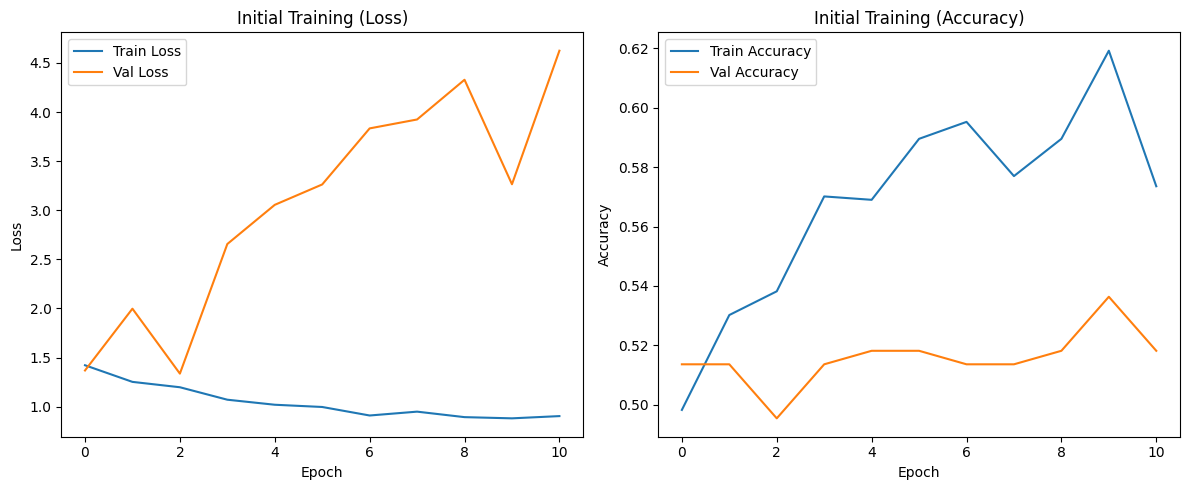

✅ Initial model saved as /content/drive/MyDrive/cnnprojectfinal/best_model.h5
🔧 Starting fine-tuning...
Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 1.1514 - accuracy: 0.4926
Epoch 1: val_loss improved from inf to 1.44979, saving model to /content/drive/MyDrive/cnnprojectfinal/best_model.h5
28/28 [==============================] - 76s 2s/step - loss: 1.1514 - accuracy: 0.4926 - val_loss: 1.4498 - val_accuracy: 0.5091 - lr: 1.0000e-05
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.5701
Epoch 2: val_loss did not improve from 1.44979
28/28 [==============================] - 61s 2s/step - loss: 0.9770 - accuracy: 0.5701 - val_loss: 1.6078 - val_accuracy: 0.5182 - lr: 1.0000e-05
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.9552 - accuracy: 0.5781
Epoch 3: val_loss did not improve from 1.44979
28/28 [==============================] - 64s 2s/step - loss: 0.9552 - accuracy: 0.5781 - val_loss: 1.6582 - val

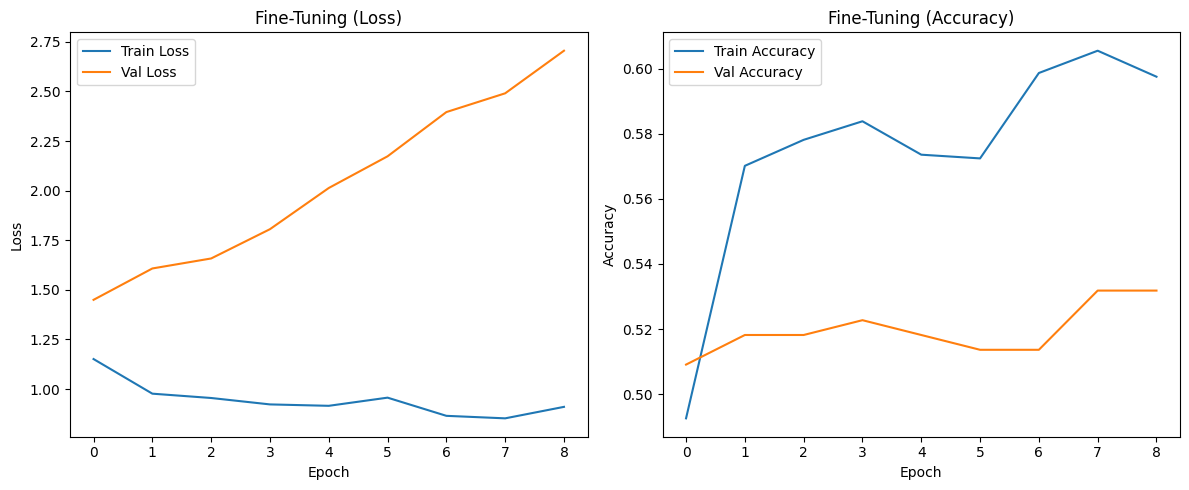

✅ Final model saved as /content/drive/MyDrive/cnnprojectfinal/final_model.h5


In [6]:
import sys
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Set your project root path
project_path = '/content/drive/MyDrive/cnnprojectfinal'
if project_path not in sys.path:
    sys.path.append(project_path)

from utils.data_processing import DataProcessor
from utils.model_transfer import create_model_transfer

# Option to use focal loss instead of standard cross-entropy
USE_FOCAL_LOSS = False  # Change to True to use focal loss
if USE_FOCAL_LOSS:
    import tensorflow_addons as tfa

#############################################
# Training and Plotting Functions
#############################################
def train_model_fn(model, train_generator, val_generator, epochs, checkpoint_path, class_weight_dict=None):
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    callbacks = [early_stop, checkpoint, reduce_lr]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    return history

def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title + " (Loss)")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title + " (Accuracy)")

    plt.tight_layout()
    plt.show()

#############################################
# Main Training and Fine-Tuning Workflow
#############################################
if __name__ == '__main__':
    # Initialize the data processor with target size 224x224.
    processor = DataProcessor(target_size=(224, 224))
    train_gen, val_gen, X_val, y_val = processor.create_generators(batch_size=32)

    # Compute class weights from training labels, if available.
    try:
        y_train = train_gen.classes
    except AttributeError:
        # If not available, you might need to compute it from your data manually.
        y_train = None

    class_weight_dict = None
    if y_train is not None:
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
        print("Computed class weights:", class_weight_dict)

    # Define path to save the best model.
    model_path = '/content/drive/MyDrive/cnnprojectfinal/best_model.h5'

    # Create the MobileNetV2-based transfer learning model.
    model = create_model_transfer(input_shape=(224, 224, 1), num_classes=3)

    # Optionally, recompile with focal loss.
    if USE_FOCAL_LOSS:
        model.compile(optimizer='adam', loss=tfa.losses.SigmoidFocalCrossEntropy(), metrics=['accuracy'])

    print("🚀 Starting initial training...")
    initial_epochs = 50
    history_initial = train_model_fn(model, train_gen, val_gen, epochs=initial_epochs, checkpoint_path=model_path, class_weight_dict=class_weight_dict)
    plot_training_history(history_initial, title="Initial Training")

    # Save the model after initial training.
    model.save(model_path)
    print(f"✅ Initial model saved as {model_path}")

    # ----------------- Fine-Tuning Phase -----------------
    print("🔧 Starting fine-tuning...")
    # Retrieve the base model by its name.
    base_model = model.get_layer("MobileNetV2_base")
    base_model.trainable = True
    # Unfreeze all layers except the first ones; here we unfreeze the last 30 layers.
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Recompile with a lower learning rate.
    if USE_FOCAL_LOSS:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tfa.losses.SigmoidFocalCrossEntropy(),
                      metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    fine_tune_epochs = 20
    history_fine = train_model_fn(model, train_gen, val_gen, epochs=fine_tune_epochs, checkpoint_path=model_path, class_weight_dict=class_weight_dict)
    plot_training_history(history_fine, title="Fine-Tuning")

    final_model_path = '/content/drive/MyDrive/cnnprojectfinal/final_model.h5'
    model.save(final_model_path)
    print(f"✅ Final model saved as {final_model_path}")


**Step 6: Model Evaluation**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_model(model, X_val, y_val, class_names=['benign', 'malignant', 'normal'], compute_auc=False):
    """
    Evaluates the model on validation data and prints key metrics.

    Parameters:
      - model: A trained Keras model.
      - X_val: Validation images (preprocessed).
      - y_val: True labels.
      - class_names: List of class names.
      - compute_auc: Boolean flag to compute ROC-AUC for multi-class.
    """
    # Generate prediction probabilities and convert to class labels.
    y_pred_probs = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    print("Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Plot confusion matrix.
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Compute and print per-class accuracy.
    class_acc = {}
    for i, class_name in enumerate(class_names):
        mask = (y_val == i)
        class_acc[class_name] = np.mean(y_pred_classes[mask] == y_val[mask])
    print("Class-wise Accuracy:")
    for class_name, acc in class_acc.items():
        print(f"{class_name}: {acc:.2%}")

    # Compute overall accuracy.
    overall_acc = accuracy_score(y_val, y_pred_classes)
    print(f"Overall Accuracy: {overall_acc:.2%}")

    # Optionally compute ROC-AUC score.
    if compute_auc:
        try:
            y_val_bin = label_binarize(y_val, classes=range(len(class_names)))
            auc = roc_auc_score(y_val_bin, y_pred_probs, multi_class='ovr')
            print(f"ROC-AUC Score: {auc:.4f}")
        except Exception as e:
            print("Error computing ROC-AUC Score:", e)


**Step 7: Implementation of Explainable AI (Grad-CAM)**

In [14]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name='block_16_project', class_index=None):
    """
    Generates a Grad-CAM heatmap for the given image using the specified layer.

    If the layer is not found at the top level, it attempts to retrieve it from the
    MobileNetV2_base sub-model.

    Parameters:
      - model: A trained Keras model.
      - img_array: Preprocessed image array of shape (1, H, W, C).
      - layer_name: The name of the convolutional layer to use (default: 'block_16_project').
      - class_index: (Optional) Target class index; if None, uses the class with the highest prediction.

    Returns:
      - superimposed_img: The original image (in BGR) overlaid with the Grad-CAM heatmap.
    """
    # Try to retrieve the target layer from the top-level model.
    try:
        target_layer = model.get_layer(layer_name)
    except ValueError:
        # If not found, try to get it from the MobileNetV2_base sub-model.
        base_model = model.get_layer("MobileNetV2_base")
        try:
            target_layer = base_model.get_layer(layer_name)
        except ValueError:
            raise ValueError(f"Layer {layer_name} not found in the model or in MobileNetV2_base.")

    grad_model = tf.keras.models.Model([model.inputs], [target_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = np.uint8(255 * img_array[0].squeeze())
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    return superimposed_img

def visualize_explanations(model, X_val, y_val, num_samples=3, layer_name='block_16_project'):
    """
    Visualizes Grad-CAM explanations for a random subset of validation images.

    Parameters:
      - model: A trained Keras model.
      - X_val: Array of validation images (preprocessed as during training).
      - y_val: True labels corresponding to X_val.
      - num_samples: Number of samples to visualize.
      - layer_name: The name of the layer to use for Grad-CAM (default: 'block_16_project').
    """
    class_names = ['benign', 'malignant', 'normal']
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices, 1):
        img = X_val[idx]
        true_label = class_names[y_val[idx]]
        pred = model.predict(np.expand_dims(img, axis=0))
        pred_class = class_names[np.argmax(pred)]
        # Pass the chosen layer_name to grad_cam.
        explanation = grad_cam(model, np.expand_dims(img, axis=0), layer_name=layer_name)

        plt.subplot(num_samples, 2, 2 * i - 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_class}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i)
        plt.imshow(explanation)
        plt.title("Grad-CAM Explanation")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [19]:
from utils.xai import visualize_explanations
dummy_labels = np.zeros(len(test_images), dtype=int)
visualize_explanations(model, test_images, dummy_labels, num_samples=3, layer_name='block_16_project')


TypeError: visualize_explanations() got an unexpected keyword argument 'layer_name'

**Step 8: Testing Model Accuracy on Test images**

In [13]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def load_test_images(test_dir, target_size=(224,224)):
    """
    Loads and preprocesses test images from the specified directory.

    Parameters:
      - test_dir: Directory containing test images.
      - target_size: Desired size for the images.

    Returns:
      - images: NumPy array of test images with shape (N, H, W, 1), normalized to [0,1].
      - image_paths: List of file paths for the images.
    """
    test_dir = Path(test_dir)
    images = []
    image_paths = list(test_dir.glob('*'))
    for img_path in image_paths:
        if img_path.suffix.lower() in ('.png', '.jpg', '.jpeg'):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img[..., np.newaxis] / 255.0)
    return np.array(images), image_paths

# Example usage:
# Assuming your model is loaded in a variable called 'model'
test_images, test_paths = load_test_images("/content/drive/MyDrive/cnnprojectfinal/data/raw/test", target_size=(224,224))
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
class_names = ['benign', 'malignant', 'normal']
for path, pred in zip(test_paths, predicted_classes):
    print(f"Image: {path.name}, Predicted Class: {class_names[pred]}")

# Optionally, visualize Grad-CAM explanations for a few test images.
from utils.xai import visualize_explanations
# If you have true labels for test images, replace dummy_labels with them; otherwise, we use zeros.
dummy_labels = np.zeros(len(test_images), dtype=int)
visualize_explanations(model, test_images, dummy_labels, num_samples=3)


7/7 [==============================] - 11s 2s/step
Image: 003038_05_01_063.png, Predicted Class: malignant
Image: 000315_04_03_145.png, Predicted Class: normal
Image: 001083_09_01_093.png, Predicted Class: malignant
Image: 003380_03_01_140.png, Predicted Class: malignant
Image: 000328_08_03_180.png, Predicted Class: malignant
Image: 002265_01_01_016.png, Predicted Class: malignant
Image: 002435_04_01_230.png, Predicted Class: malignant
Image: 003412_03_01_108.png, Predicted Class: malignant
Image: 002463_01_01_029.png, Predicted Class: normal
Image: 002701_04_03_160.png, Predicted Class: malignant
Image: 001797_01_02_221.png, Predicted Class: malignant
Image: 003601_02_01_076.png, Predicted Class: malignant
Image: 002265_02_01_031.png, Predicted Class: normal
Image: 001404_01_01_139.png, Predicted Class: malignant
Image: 000316_01_01_071.png, Predicted Class: malignant
Image: 002276_05_03_078.png, Predicted Class: normal
Image: 002601_01_01_237.png, Predicted Class: normal
Image: 00212

ValueError: No such layer: conv2d_2. Existing layers are: ['input_1', 'concatenate', 'lambda', 'MobileNetV2_base', 'global_average_pooling2d', 'batch_normalization', 'dense', 'dropout', 'dense_1'].

<Figure size 1500x1500 with 0 Axes>